In [61]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import transformers

from torch import cuda
# from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer

In [2]:
TEST_TEXT = "Where is the volume button of the iPhone 12?"

In [3]:
TOKEN_PATH = '../models/vocab_distilbert_amazon_weighted.bin'
MODEL_PATH = '../models/pytorch_distilbert_amazon_weighted.bin'

In [4]:
device = 'cuda' if cuda.is_available() else 'cpu'

In [5]:
class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        
        # set the shape = (768, number_of_classes)
        self.classifier = torch.nn.Linear(768, 21)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [6]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained(TOKEN_PATH)
inputs = tokenizer.encode_plus(TEST_TEXT, return_tensors="pt", add_special_tokens=True)

Calling DistilBertTokenizer.from_pretrained() with the path to a single file or url is deprecated


In [9]:
model = DistillBERTClass()
model.to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

In [20]:
def predict(model, inputs):
    model.eval()
    with torch.no_grad():
        ids = inputs['input_ids'].to(device, dtype = torch.long)
        mask = inputs['attention_mask'].to(device, dtype = torch.long)
        outputs = model(ids, mask)
        
    big_val, big_idx = torch.max(outputs.data, dim=1)
    
    return big_idx[0].item(), outputs

In [51]:
result, output = predict(model, inputs)

In [52]:
category_list = [
    'appliances',
    'arts_crafts_and_sewing',
    'automotive',
    'baby',
    'beauty',
    'cell_phones_and_accessories',
    'clothing_shoes_and_jewelry',
    'electronics',
    'grocery_and_gourmet_food',
    'health_and_personal_care',
    'home_and_kitchen',
    'industrial_and_scientific',
    'musical_instruments',
    'office_products',
    'patio_lawn_and_garden',
    'pet_supplies',
    'software',
    'sports_and_outdoors',
    'tools_and_home_improvement',
    'toys_and_games',
    'video_games',
]
print(category_list[result])

cell_phones_and_accessories


In [92]:
list(output.cpu().data.numpy()[0])

[-6.529423,
 -4.903955,
 -3.0369368,
 -3.7639055,
 -4.7158995,
 2.0263038,
 -4.429103,
 0.25162953,
 -7.4894295,
 -2.202316,
 -3.9154487,
 -5.3220596,
 -2.558313,
 -2.1982684,
 -4.481778,
 -4.939231,
 -4.947886,
 -1.7501698,
 -2.7591174,
 -2.116437,
 -3.293511]

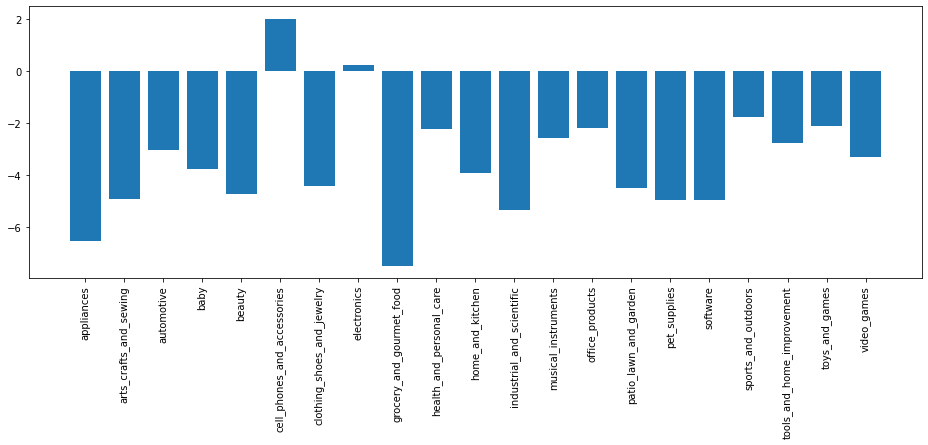

In [88]:
plt.figure(figsize=(16,5))
plt.bar(
    category_list,
    list(output.cpu().data.numpy()[0])
)
plt.xticks(rotation=90);

In [94]:
output.cpu()

tensor([[-6.5294, -4.9040, -3.0369, -3.7639, -4.7159,  2.0263, -4.4291,  0.2516,
         -7.4894, -2.2023, -3.9154, -5.3221, -2.5583, -2.1983, -4.4818, -4.9392,
         -4.9479, -1.7502, -2.7591, -2.1164, -3.2935]])